# **1D Diffusion Approximated via PINN**
**6/24**
<br>
Utilizing Pytorch and Torchdyn libraries in order to create a PINN that will approximate our test case (1D diffusion). This notebook will be heavily annotated, since this will be my first attempt at creating, training, and utilizing a neural net. To do: benchmark speed and accuracy of each solution in a singular notebook/script.

$$\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2}$$

### **Pure Pytorch PINN**
Pytorch is an open-source and generalized machine learning library developed by FAIR. It was built for python and features optimizeds tensors, autograd, modular NNs, and dynamic computation graphs. Pytorch is a great tool on it's own but with library extensions, it can be _more_ specialized.

#### **Training**

Epoch 200, Loss: 0.0126056969165802
Epoch 400, Loss: 0.0005997801199555397
Epoch 600, Loss: 0.0002765449171420187
Epoch 800, Loss: 0.00015357507800217718
Epoch 1000, Loss: 0.00010305475007044151
Epoch 1200, Loss: 8.556732791475952e-05
Epoch 1400, Loss: 8.700751641299576e-05
Epoch 1600, Loss: 6.245037366170436e-05
Epoch 1800, Loss: 5.778333797934465e-05
Epoch 2000, Loss: 7.259444100782275e-05


Text(0.5, 1.0, 'Training Loss Over Time')

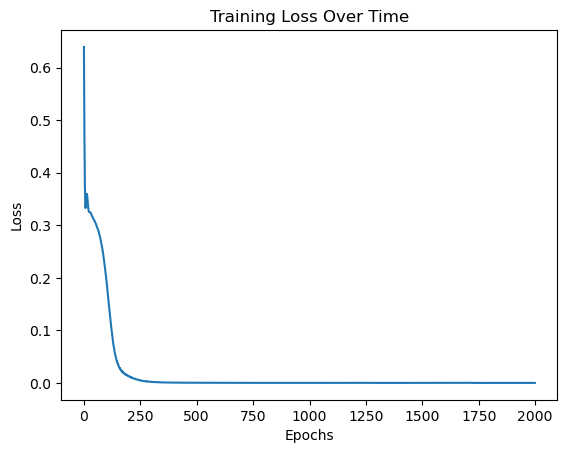

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Manually set the random seed for reproducibility
torch.manual_seed(42)

# This is where we define the architecture of our neural network
# We define a Multi-Layer Perceptron (MLP) that will be used to approximate the solution of the PDE
# The MLP will take in two inputs (x and t) and output a single value
class MLP(nn.Module):

    # Define the constructor for the MLP class
    # This class inherits from nn.Module, which is the base class for all neural network modules
    # The MLP consists of three linear layers with Tanh activation functions in between, all of which can be modified
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),  nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    
    # The forward method defines how the input data flows through the network
    # It takes a tensor x as input and returns the output of the network
    def forward(self, x):
        return self.net(x)

#  Loss functions:

# The PDE loss function computes the residual of the PDE at sampled points (x, t)
# It uses automatic differentiation to compute the gradients of the output with respect to the inputs
def pde_loss(model, x, t, D=0.1):

    # Create a tensor xt that combines x and t, and requires gradients
    xt = torch.stack([x, t], dim=1).requires_grad_(True)  # shape: [N, 2]

    # Column vector of predicted solutions u at points (x, t)
    u = model(xt)

    # Compute gradients of u with respect to xt and store them in tensor grads
    # This will give us the first derivatives of u with respect to x and t
    grads = torch.autograd.grad(u, xt, torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:, 0]
    u_t = grads[:, 1]

    # Compute the second derivative of u with respect to x (right-hand side of the PDE)
    grads2 = torch.autograd.grad(u_x, xt, torch.ones_like(u_x), create_graph=True)[0]
    u_xx = grads2[:, 0]

    # Compute the PDE residual: u_t - D * u_xx
    # This is the mean squared error of the PDE, which we seek to minimize
    return torch.mean((u_t - D * u_xx) ** 2)


# Initial condition loss function
def ic_loss(model):
    # Define spatial points at t=0
    x0 = torch.linspace(0, 1, 100)
    t0 = torch.zeros_like(x0)

    # Stack x0 and t0 to create a tensor xt0
    xt0 = torch.stack([x0, t0], dim=1)

    # Compute the model's output at the initial condition
    # The output should match the initial condition u(x, 0) = sin(pi * x)
    u0 = model(xt0).squeeze()

    # Compute the mean squared error between the model's output and the initial condition
    return torch.mean((u0 - torch.sin(np.pi * x0)) ** 2)

# Boundary condition loss function
def bc_loss(model):
    # Define all time steps t for x=0 and x=1
    t = torch.linspace(0, 1, 100)
    xb0 = torch.zeros_like(t)
    xb1 = torch.ones_like(t)

    # Create two sets of points: one for the left boundary (x=0) and one for the right boundary (x=1)
    xt0 = torch.stack([xb0, t], dim=1)
    xt1 = torch.stack([xb1, t], dim=1)

    # Return the loss
    return torch.mean(model(xt0)**2) + torch.mean(model(xt1)**2)

# Training loop
model = MLP() # Our neural network model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam optimizer for training the model
# Note: I selected the Adam optimizer for its efficiency in training deep learning models, although there are other optimizers available in PyTorch
# Adam is particularly well-suited for problems with large datasets and high-dimensional parameter spaces, and is typically a good default choice for training neural networks

epochs = 2000 # Number of training epochs
losses = [] # List to store loss values for plotting

# Training the model
for epoch in range(epochs):
    # Zero the gradients of the model parameters
    # This is necessary to prevent accumulation of gradients from previous iterations
    optimizer.zero_grad()

    # Sample points for loss
    x = torch.rand(1000)
    t = torch.rand(1000)

    # Compute the losses
    # The losses are computed based on the PDE, initial condition, and boundary conditions
    loss_pde = pde_loss(model, x, t)
    loss_ic = ic_loss(model)
    loss_bc = bc_loss(model)

    # Total loss is the sum of the individual losses
    # The total loss is what we will minimize during training
    # Can modify the weights depending on other problems
    # Here, we assume equal weights for simplicity
    loss = loss_pde + loss_ic + loss_bc

    # Backpropagation step
    # This step computes the gradients of the loss with respect to the model parameters
    loss.backward()
    # Update the model parameters using the optimizer
    optimizer.step()
    losses.append(loss.item())

    # Print loss every 200 epochs
    # This is useful for monitoring the training process and ensuring that the model is learning
    if (epoch + 1) % 200 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

# Plotting loss over epochs
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')

We successfully trained our PINN. As we can see, the loss is now negligible (for our current purposes) at a value of roughly $7.26 \times 10^{-5}$ in 2000 epochs. Now we will utilize this PINN to actually evaluate our PDE before moving onto our Torchdyn architecture.
<br><br>
As a sidenote, I've been using a standard matplot line plot to visualize the evolution of the diffusion equation since it felt intuitive and a nice starting point. For this notebook, I'll be utilizing heatmaps and likely an animated heatmap for the Torchdyn PINN, as I feel that will be a useful tool moving forward.

#### **Implementation**

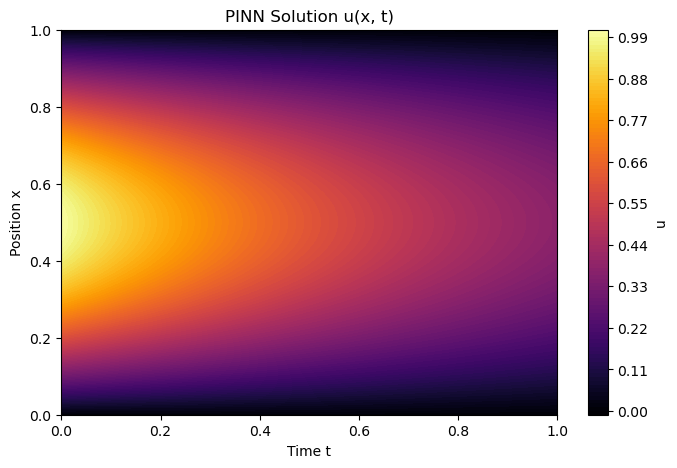

In [3]:
# Create a grid of (x, t) values
x_vals = torch.linspace(0, 1, 100)
t_vals = torch.linspace(0, 1, 100)
X, T = torch.meshgrid(x_vals, t_vals, indexing='ij')  # shape [100, 100]

# Flatten the grid and evaluate the model
xt = torch.stack([X.flatten(), T.flatten()], dim=1)  # shape [10000, 2]
with torch.no_grad():
    U = model(xt).reshape(100, 100)  # reshape back to [x, t] grid

# Save the results in a DataFrame
df = pd.DataFrame({
    'x': X.flatten().numpy(),
    't': T.flatten().numpy(),
    'u': U.flatten().numpy()
})

# save to .csv
df.to_csv('pinn_solution.csv', index=False)

plt.figure(figsize=(8, 5))
plt.contourf(T, X, U, 100, cmap='inferno')
plt.xlabel("Time t")
plt.ylabel("Position x")
plt.title("PINN Solution u(x, t)")
plt.colorbar(label="u")
plt.show()

We do want the standard lineplot for comparison purposes, though so it is plotted here:

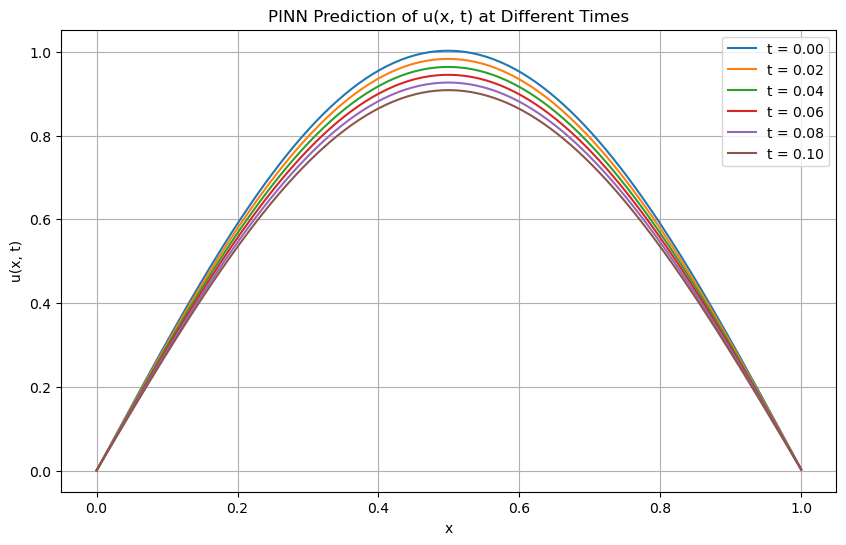

In [ ]:
x_vals = torch.linspace(0, 1, 200)  # High-resolution x grid
t_values = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1]

plt.figure(figsize=(10, 6))

with torch.no_grad():
    for t_val in t_values:
        t_tensor = torch.full_like(x_vals, t_val)  # Create [t_val, t_val, ..., t_val]
        xt = torch.stack([x_vals, t_tensor], dim=1)  # Shape: [200, 2]
        U = model(xt).squeeze()  # Predict u(x, t_val)

        plt.plot(x_vals.numpy(), U.numpy(), label=f"t = {t_val:.2f}")

plt.title("PINN Prediction of u(x, t) at Different Times")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.grid(True)
plt.show()

### **Pytorch w/ Torchdyn PINN**
Torchdyn is a specialized extension of the Pytorch library developed by University of Oxford's Applied Deep Learning group. Torchdyn is specifically designed to handle neural differential equations including neural ODEs, PINNs, and control + dynamics modeling. It's meant to streamline most of the work we just did of creating an training the neural net above.
<br><br>
Think of Pytorch as NumPy and Torchdyn as SciPy- simply a specialized extension of a core library.

 #### **Training**